# Transak iteration 1
Feature Engineering with TensorFlow using old API tf.feature_column

## I used knowledge from those courses 
- GCP Proffesional Machine Learning Engineer course 4 Feature Engineering, modules 3,5,6,7,8,9
- Machine Learning Mastery course from Adam Dobrakowski

## Assumptions
1. Floats change into categorical bins (MLE 4.3.1) - quntiles with same number of examples per bin? - perhaps in next iteration with Keras or tf.Transform. Now I need fast next level from benchmark model.
2. Cyclic transformation of dates should allow better identify Abos
3. Environment has tensorflow==2.12.1, because this supports old tf.feature_column API and Keras DenseFeatures layer, which I need to learn for the exam.

# Development

## Imports

In [1]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import feature_column as fc
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib
import matplotlib.pyplot as plt
# from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
#                              classification_report, confusion_matrix)
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(f"BigQuery client library version: {bigquery.__version__}")
print(f"Tensorflow version: {tf.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Keras version: {tf.keras.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")


BigQuery client library version: 3.9.0
Tensorflow version: 2.12.1
Pandas version: 1.5.3
Keras version: 2.12.0
Matplotlib version: 3.7.1


## Data load

In [2]:
bq = bigquery.Client(project="af-finanzen")
query = """
  WITH EDA AS (
    SELECT
        tid
      , type
      --AF20250604 I need Cyclic because of minmax normalization , UNIX_SECONDS(started) started -- TF works with numbers or strings, not with timestamps
      --AF20250604 I need Cyclic because of minmax normalization , UNIX_SECONDS(first_started) first_started -- this should be part of feature engineering or ingestion ale update?
      --AF20250604 I need Cyclic because of minmax normalization   -- if this is here, then it is easier do train test eval split because here it is done on all data,
      --AF20250604 I need Cyclic because of minmax normalization   -- an not on train or test or validation separately where it would be different. Same for min max and so on.. 
      , started
      , first_started
      , LOWER(description) description -- i1_eda_conclusion_2
      , amount
      --, fee
      , currency
      --, state
      --, account
      , CASE
          WHEN i1_true_label = 'PK Prezenty' THEN 'PK Rest'
          WHEN i1_true_label = 'PK Auto' THEN 'PK Rest'
          --WHEN i1_true_label = 'Exchange' THEN 'PK Rest'
          --WHEN i1_true_label = 'SK Haushalt' THEN 'PK Rest'
          --WHEN i1_true_label = 'PK Medic' THEN 'PK Rest'
          --WHEN i1_true_label = 'PK Abo' THEN 'PK Rest'
          --WHEN i1_true_label = 'PK Maja' THEN 'PK Rest'
          --WHEN i1_true_label = 'eShop' THEN 'PK Rest'
          --WHEN i1_true_label = 'SK Ferien' THEN 'PK Rest'
          --WHEN i1_true_label = 'PK Artur' THEN 'PK Rest'
          --WHEN i1_true_label = 'PK Reisen' THEN 'PK Rest'
          --WHEN i1_true_label = 'PK Leben' THEN 'PK Rest'
          --WHEN i1_true_label = 'PK Kasia' THEN 'PK Rest'
          WHEN i1_true_label = 'Apt' THEN 'PK Kasia'
          --WHEN i1_true_label = 'Apt' THEN 'PK Rest'
          ELSE i1_true_label
        END AS i1_true_label
    FROM `af-finanzen.monatsabschluss.revolut_abrechnung`
    WHERE
      type NOT IN ("FEE", "ATM") -- i1_eda_conclusion_1
      AND ABS(amount) < 300
    ORDER BY started
  ),
  LABEL_INT AS (
    SELECT
      *
      , DENSE_RANK() OVER(ORDER BY i1_true_label) - 1 AS i1_true_label_id
    FROM EDA
  ),
  SPLIT_SET AS (
    SELECT
        tid
      , i1_true_label
      , CASE
          WHEN ABS(MOD(tid, 10)) <= 7 THEN 'train'
          WHEN ABS(MOD(tid, 10)) = 8 THEN 'validation'
          WHEN ABS(MOD(tid, 10)) = 9 THEN 'test'
          -- WHEN ABS(MOD(tid, 100)) < 60 THEN 'train'
          -- WHEN ABS(MOD(tid, 100)) BETWEEN 60 AND 80 THEN 'validation'
          -- WHEN ABS(MOD(tid, 100)) BETWEEN 80 AND 100 THEN 'test'
          ELSE "unknown"
        END AS split_set
    FROM EDA
    GROUP BY
      i1_true_label, tid
  )
  SELECT
    LABEL_INT.* EXCEPT(tid)
    , SPLIT_SET.split_set
  FROM LABEL_INT
  JOIN SPLIT_SET
  ON LABEL_INT.tid = SPLIT_SET.tid
"""
df = bq.query(query).to_dataframe()

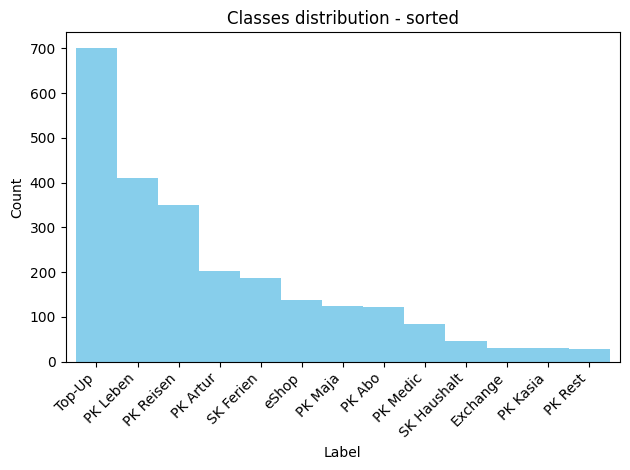

In [3]:
df.i1_true_label.value_counts().plot(kind="bar", width=1, color="skyblue")
plt.ylabel("Count")
plt.xlabel("Label")
plt.title("Classes distribution - sorted")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Reverse mapping of label names and ids

In [4]:
rev_mapping_df = df.pop("i1_true_label")

In [5]:
#df.drop(columns=['i1_true_label'], inplace=True)
rev_mapping_df = pd.concat([rev_mapping_df, df.i1_true_label_id], axis=1)
rev_mapping_df = (rev_mapping_df
                  .drop_duplicates()
                  .sort_values(by='i1_true_label_id')
                  .reset_index(drop=True))

class_names=rev_mapping_df.i1_true_label.tolist()

rev_mapping_df

,i1_true_label,i1_true_label_id
0,Exchange,0
1,PK Abo,1
2,PK Artur,2
3,PK Kasia,3
4,PK Leben,4
5,PK Maja,5
6,PK Medic,6
7,PK Reisen,7
8,PK Rest,8
9,SK Ferien,9


# Cyclic transformations

In [6]:
df['started_day'] = df.started.dt.day
df['started_day_sin'] = np.sin((df.started_day-1)*(2.*np.pi/31))
df['started_day_cos'] = np.cos((df.started_day-1)*(2.*np.pi/31))
df['started_month'] = df.started.dt.month
df['started_month_sin'] = np.sin((df.started_month-1)*(2.*np.pi/12))
df['started_month_cos'] = np.cos((df.started_month-1)*(2.*np.pi/12))
# can not by normalized df['started_year'] = df.started.dt.year
df.drop(columns=['started'], inplace=True)

In [7]:
df['first_started_day'] = df.first_started.dt.day
df['first_started_day_sin'] = np.sin((df.first_started_day-1)*(2.*np.pi/31))
df['first_started_day_cos'] = np.cos((df.first_started_day-1)*(2.*np.pi/31))
df['first_started_month'] = df.first_started.dt.month
df['first_started_month_sin'] = np.sin((df.first_started_month-1)*(2.*np.pi/12))
df['first_started_month_cos'] = np.cos((df.first_started_month-1)*(2.*np.pi/12))
df['first_started_year'] = df.first_started.dt.year
df.drop(columns=['first_started'], inplace=True)

# Train, test, validation split

In [8]:
train_df = df[df['split_set'] == 'train'].drop(columns=['split_set'])
test_df = df[df['split_set'] == 'test'].drop(columns=['split_set'])
val_df = df[df['split_set'] == 'validation'].drop(columns=['split_set'])
print(df.shape, 'all examples and columns')
print(len(train_df), 'train examples')
print(len(test_df), 'test examples')
print(len(val_df), 'validation examples')

(2454, 19) all examples and columns
1983 train examples
243 test examples
228 validation examples


## Transform Pandas DF into Tensorflow Dataset

In [9]:
def df2dataset(df: pd.DataFrame, shuffle=True, batch_size=32):
    df = df.copy()
    labels = df.pop("i1_true_label_id").astype(np.int64)
    for col in df.columns:
        if isinstance(df[col].dtype, pd.Int64Dtype):
            # It's often safest to convert feature columns to float32,
            # as it naturally handles potential missing values if you need them.
            # also solves ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).
            print(f"Converting feature column '{col}' from Int64 to float32.")
            df[col] = df[col].astype(np.float32)
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df), seed=42)
    # ds.map(lambda...) MLE 4.3.2
    ds = ds.batch(batch_size=batch_size)
    return ds

In [10]:
train_ds = df2dataset(train_df)
val_ds = df2dataset(val_df, shuffle=True)
for feature_batch, label_batch in train_ds.take(1):
    print(f'List of feature names: {list(feature_batch.keys())}')
    print(f'Batch of type: {feature_batch["type"]}')
    print(f'Batch of labels: {label_batch}')

List of feature names: ['type', 'description', 'amount', 'currency', 'started_day', 'started_day_sin', 'started_day_cos', 'started_month', 'started_month_sin', 'started_month_cos', 'first_started_day', 'first_started_day_sin', 'first_started_day_cos', 'first_started_month', 'first_started_month_sin', 'first_started_month_cos', 'first_started_year']
Batch of type: [b'TOPUP' b'TOPUP' b'CARD_PAYMENT' b'TOPUP' b'CARD_PAYMENT'
 b'CARD_PAYMENT' b'CARD_PAYMENT' b'CARD_PAYMENT' b'CARD_PAYMENT' b'TOPUP'
 b'CARD_PAYMENT' b'CARD_PAYMENT' b'TOPUP' b'CARD_PAYMENT' b'CARD_PAYMENT'
 b'TRANSFER' b'TOPUP' b'CARD_PAYMENT' b'CARD_PAYMENT' b'CARD_PAYMENT'
 b'TOPUP' b'CARD_PAYMENT' b'CARD_PAYMENT' b'TOPUP' b'CARD_PAYMENT'
 b'CARD_PAYMENT' b'CARD_PAYMENT' b'CARD_PAYMENT' b'CARD_PAYMENT'
 b'CARD_PAYMENT' b'CARD_PAYMENT' b'TRANSFER']
Batch of labels: [11 11  9 11  4  7  4  9  4 11  7  9 11  9 12  2 11  7  5  5 11  9  4 11
  7  1  2  1  2 12  1  5]


# Feature Columns

In [11]:
feature_columns = []

Numerical columns

In [12]:
numerical_col_names_normalized = ['started_day_sin', 'started_day_cos', 'started_month_sin', 'started_month_cos', 'first_started_day_sin', 'first_started_day_cos', 'first_started_month_sin', 'first_started_month_cos']
# numerical_col_names_to_normalize = ['amount', 'fee', 'started_day', 'started_month', 'first_started_day', 'first_started_month', 'first_started_year']
# numerical_col_names_to_normalize = ['amount', 'started_day', 'started_month', 'first_started_day', 'first_started_month', 'first_started_year']
numerical_col_names_to_normalize = ['amount']

In [13]:
for feature_name in numerical_col_names_normalized:
    feature_columns.append(fc.numeric_column(feature_name))

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


In [14]:
STATS = {}
for feature in numerical_col_names_to_normalize:
    min_val = train_df[feature].min()
    max_val = train_df[feature].max()
    
    STATS[feature] = {
        'min': min_val,
        'max': max_val
    }

def get_scaling_fn(feature: str):
    def minmax(x):
        mini = STATS[feature]['min']
        maxi = STATS[feature]['max']
        return (x-mini)/(maxi-mini + 1e-7)
    return minmax

In [15]:
for feature_name in numerical_col_names_to_normalize:
    scaling_fn = get_scaling_fn(feature_name)
    feature_columns.append(fc.numeric_column(feature_name, normalizer_fn=scaling_fn))

Categorical columns

In [16]:
# categorical_columns = ['type', 'description', 'currency', 'state', 'account']
#categorical_columns = ['type', 'description', 'currency', 'state']
categorical_columns = ['type', 'description']
#categorical_columns = ['type']
tobe_crossed = []
for feature_name in categorical_columns:
    vocabulary = df[feature_name].unique()
    feature_column = fc.categorical_column_with_vocabulary_list(feature_name, vocabulary, num_oov_buckets=1)
    if feature_name == 'description':
        feature_columns.append(fc.embedding_column(feature_column, dimension=8))
    else:
        feature_columns.append(fc.indicator_column(feature_column))

    if feature_name in ['type', 'description']:
        tobe_crossed.append(feature_column)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


Crossed features

In [17]:
type_description_cross = fc.crossed_column(tobe_crossed, hash_bucket_size=20)
type_description_cross = fc.indicator_column(type_description_cross)
feature_columns.append(type_description_cross)

Instructions for updating:
Use `tf.keras.layers.experimental.preprocessing.HashedCrossing` instead for feature crossing when preprocessing data to train a Keras model.


# Model training

In [18]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

model = tf.keras.Sequential([
    feature_layer,
    layers.Dense(80, input_dim=20, activation='relu'),
    layers.Dense(40, activation='relu'),
    layers.Dense(len(class_names), activation='softmax', name='i1_pred_label_id'),
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss',  # seen in earlier output, the metric to watch
                               patience=5,          # how many epochs to wait for improvement
                               verbose=1,           # print message when stop
                               restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='best_model.h5',
                                   monitor='val_loss',
                                   save_best_only=True,
                                   verbose=1)
history = model.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=100,
                    callbacks=[early_stopping, model_checkpoint])


Epoch 1/100
55/62 [=========================>....] - ETA: 0s - loss: 1.9950 - accuracy: 0.3881WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor. Received: inputs={'type': <tf.Tensor 'IteratorGetNext:16' shape=(None,) dtype=string>, 'description': <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtype=string>, 'amount': <tf.Tensor 'IteratorGetNext:0' shape=(None,) dtype=float64>, 'currency': <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=string>, 'started_day': <tf.Tensor 'IteratorGetNext:10' shape=(None,) dtype=int64>, 'started_day_sin': <tf.Tensor 'IteratorGetNext:12' shape=(None,) dtype=float64>, 'started_day_cos': <tf.Tensor 'IteratorGetNext:11' shape=(None,) dtype=float64>, 'started_month': <tf.Tensor 'IteratorGetNext:13' shape=(None,) dtype=int64>, 'started_month_sin': <tf.Tensor 'IteratorGetNext:15' shape=(None,) dtype=float64>, 'started_month_cos': <tf.Tensor 'IteratorGetNext:14' shape=(None,) dtype=float64>, 'first_started_day': <tf.Tensor '

Control model's input shape

In [19]:
# Get a single batch of features from your dataset
feature_batch, label_batch = next(iter(train_ds))

num_output_columns = feature_layer(feature_batch).shape[-1]
print(f"The feature_layer is sending {num_output_columns} columns to the model.")

The feature_layer is sending 43 columns to the model.


# Model evaluation 

In [20]:
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

8/8 [==============================] - 0s 2ms/step - loss: 0.5906 - accuracy: 0.8509
Validation Loss: 0.5906
Validation Accuracy: 0.8509


In [21]:
def plot_curves(history, metrics):
    nrows=1
    ncols=2
    fig = plt.figure(figsize=(10, 5))
    for idx, key in enumerate(metrics):
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history[f'val_{key}'])
        plt.title(f"model {key}")
        plt.ylabel(key)
        plt.xlabel("epoch")
        plt.legend(['train', 'validation'], loc='upper left')

Training statistics

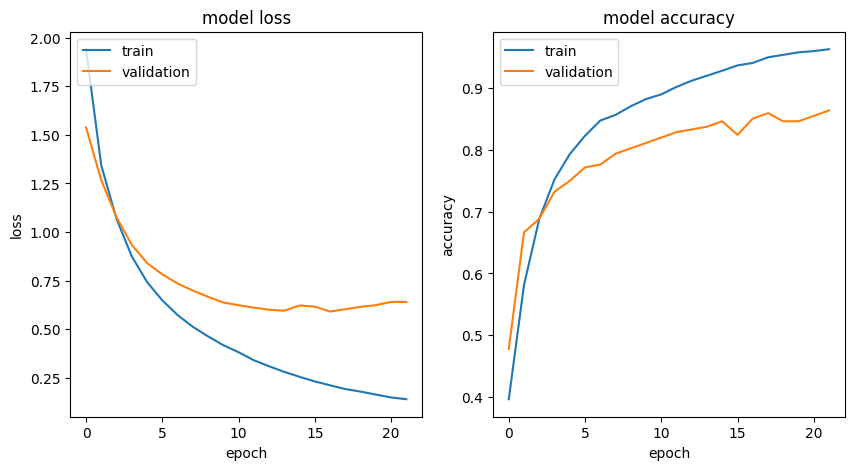

In [22]:
plot_curves(history, ['loss', 'accuracy'])

# Model test

Batch prediction

In [23]:
# without shuffle to preserve order
test_pred_ds = df2dataset(test_df, shuffle=False)
i1_pred_label_probas = model.predict(test_pred_ds)

8/8 [==============================] - 0s 2ms/step


In [24]:
i1_pred_label_probas[2]

array([3.8635612e-06, 1.4339937e-06, 2.3561101e-06, 9.7355269e-06,
       5.4480766e-05, 4.6440841e-06, 2.9395440e-05, 1.3255134e-09,
       4.1158572e-05, 6.9991081e-08, 2.2348115e-07, 9.9985254e-01,
       5.0301654e-08], dtype=float32)

Convert prediction probabilities from numpy to dataframe, adding class name and id

In [25]:
i1_pred_label_probas_df = pd.DataFrame(i1_pred_label_probas, columns=class_names)
i1_pred_label_probas_df['i1_pred_label'] = i1_pred_label_probas_df.idxmax(axis=1)
i1_pred_label_probas_df = (
    i1_pred_label_probas_df
    .merge(rev_mapping_df, left_on='i1_pred_label', right_on='i1_true_label')
    .drop(columns=['i1_true_label'])
    .rename(columns={'i1_true_label_id':'i1_pred_label_id'})
)

Combine test data with text labels and probabilities

In [26]:
rev_mapping_dict = rev_mapping_df.set_index('i1_true_label_id')['i1_true_label'].to_dict()

predicted_ids = np.argmax(i1_pred_label_probas, axis=1)
predicted_names = [rev_mapping_dict[i] for i in predicted_ids]

true_ids = test_df.i1_true_label_id.to_list()
true_names = [rev_mapping_dict[i] for i in true_ids]

test_df_preds = test_df
test_df_preds['i1_true_label'] = true_names
test_df_preds['i1_pred_label'] = predicted_names
test_df_preds['i1_pred_label_id'] = predicted_ids

test_df_preds[['i1_true_label_id', 'i1_true_label', 'i1_pred_label', 'i1_pred_label_id']]

,i1_true_label_id,i1_true_label,i1_pred_label,i1_pred_label_id
3,4,PK Leben,PK Leben,4
4,4,PK Leben,PK Leben,4
20,11,Top-Up,Top-Up,11
22,11,Top-Up,Top-Up,11
24,12,eShop,eShop,12
...,...,...,...,...
2418,7,PK Reisen,PK Reisen,7
2423,11,Top-Up,Top-Up,11
2433,7,PK Reisen,PK Reisen,7
2439,12,eShop,eShop,12


# Model Statistics

Get predicted class ids for each example

In [27]:
# y_pred = np.argmax(i1_pred_label_probas, axis=1)
y_pred = test_df_preds['i1_pred_label_id'].astype(np.int64).to_numpy()
y_pred

array([ 4,  4, 11, 11, 12,  4, 11,  6, 11,  7,  5,  7,  9,  9,  0,  4,  9,
        7,  4,  4, 10,  4, 11, 11,  4,  1, 10,  8, 11, 11,  7,  7, 12, 11,
       12,  2,  2,  4, 11,  7,  9,  1,  2,  5, 11,  8,  7,  9, 11, 11,  7,
        4,  7, 11,  1,  3,  2,  7, 11,  3, 11,  5, 11,  4, 11, 11, 11,  3,
       11,  0,  4,  4,  4, 11, 11,  5,  7,  9,  1, 11, 12,  2,  4,  7,  1,
        4,  1, 12,  4,  7,  4, 11,  5,  4,  4, 11, 11, 12,  4,  5,  1,  4,
        7,  2, 11, 11, 11, 12,  5,  7, 11,  2,  3, 11,  5,  9,  1, 11,  9,
        5,  7,  4,  4, 11,  2,  7, 11,  4, 10,  7,  4,  9, 11,  2,  9,  4,
        7, 11,  2, 11, 11,  2,  4,  5, 11,  4,  7, 11, 11,  4,  7,  9,  9,
        2,  7,  9, 11,  4, 11,  1,  4, 11,  3,  4,  7,  6,  7,  9,  7,  4,
       11, 11, 11,  4,  7, 11, 11, 11,  6,  7, 11, 12,  4,  4, 11,  0,  9,
       11, 11,  4,  2, 12, 11, 11, 11,  3,  7, 11,  1,  1,  4,  4, 12,  9,
       11, 11,  1,  9,  7,  1,  4,  4,  4,  4,  2,  6,  7,  2,  7, 12, 11,
        7,  7, 11, 12,  2

Get true class ids for each example

In [28]:
y_true = test_df_preds['i1_true_label_id'].astype(np.int64).to_numpy()
y_true

array([ 4,  4, 11, 11, 12,  4, 11,  6, 11,  2,  8,  7,  9,  9,  0,  4,  7,
        7,  4,  4,  4,  5, 11, 11,  4,  1, 10,  8, 11, 11,  7,  7, 12, 11,
       12,  2,  2,  4, 11,  4,  9,  1,  2,  5, 11,  2,  7,  9, 11, 11,  2,
        4,  7, 11,  1,  3,  9,  7, 11,  6, 11,  2, 11,  4, 11, 11, 11,  4,
       11,  0,  2,  4,  4, 11, 11,  1,  7,  9,  1, 11, 12,  2,  4,  7,  1,
        4,  8, 12,  4,  7, 12, 11,  2,  4,  4, 11, 11,  1,  4,  6,  1,  4,
        6,  9, 11, 11, 11, 12,  3,  5, 11,  2,  5, 11,  5,  9,  1, 11,  9,
        5,  7,  4,  4, 11,  2,  7, 11,  4,  5,  5,  4,  9, 11,  2,  2,  4,
        9, 11,  2, 11, 11,  8,  7,  7, 11,  4,  7, 11, 11,  4,  7,  9,  5,
        7,  7,  7, 11,  4, 11,  1,  4, 11,  3,  2,  7,  6,  7,  9,  7,  9,
       11, 11, 11,  4,  7, 11, 11, 11,  4,  7, 11, 12,  4,  4, 11,  0,  4,
       11, 11,  4,  2, 12, 11, 11, 11,  3,  7, 11,  1,  1,  4,  4,  5,  9,
       11, 11,  1,  2,  7,  1,  4,  4,  2,  4,  4,  6,  7,  5,  7, 12, 11,
        7,  7, 11, 12, 10

Classification Report

In [29]:
print("--- Classification Report ---")
print(classification_report(y_true, y_pred,target_names=class_names))

--- Classification Report ---
              precision    recall  f1-score   support

    Exchange       1.00      1.00      1.00         3
      PK Abo       0.93      0.87      0.90        15
    PK Artur       0.58      0.50      0.54        22
    PK Kasia       0.50      0.75      0.60         4
    PK Leben       0.85      0.87      0.86        45
     PK Maja       0.27      0.27      0.27        11
    PK Medic       0.75      0.43      0.55         7
   PK Reisen       0.81      0.85      0.83        34
     PK Rest       0.50      0.25      0.33         4
   SK Ferien       0.65      0.76      0.70        17
 SK Haushalt       0.33      0.33      0.33         3
      Top-Up       1.00      1.00      1.00        66
       eShop       0.85      0.92      0.88        12

    accuracy                           0.81       243
   macro avg       0.69      0.68      0.68       243
weighted avg       0.81      0.81      0.80       243



Confusion Matrix


--- Confusion Matrix ---


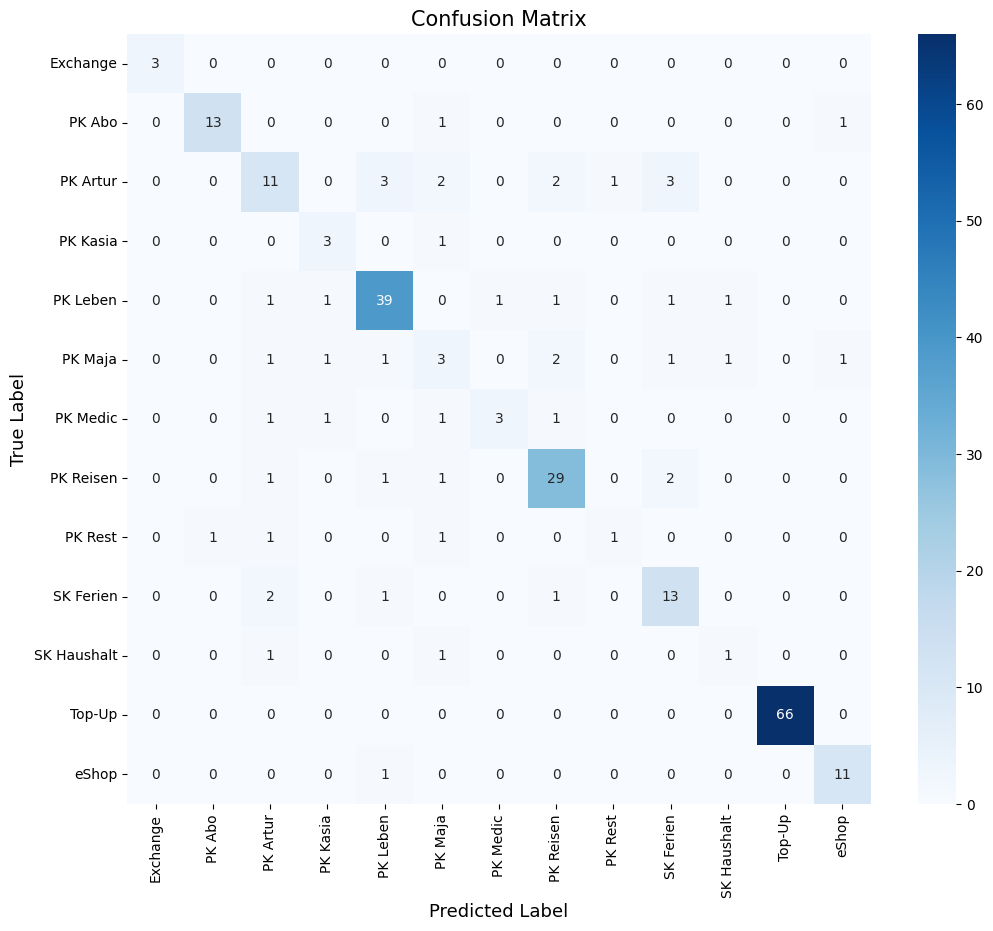

In [30]:
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm,
            annot=True,
            fmt='g',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel('Predicted Label', fontsize=13)
plt.ylabel('True Label', fontsize=13)
plt.title('Confusion Matrix', fontsize=15)
plt.show()

# Debug deta for the model with Google Facets

Prepare data

In [31]:
def prepare_df_for_libraries(df: pd.DataFrame) -> pd.DataFrame:
    """Converts special pandas dtypes to standard numpy dtypes."""
    df_copy = df.copy()
    for col in df_copy.columns:
        # Check for the nullable integer type
        if isinstance(df_copy[col].dtype, pd.Int64Dtype):
            print(f"Converting column '{col}' from nullable Int64 to standard int64.")
            # We must handle potential missing values (NaN) before converting to a standard integer.
            # Here, we'll fill any missing values with 0.
            df_copy[col] = df_copy[col].fillna(0).astype(np.int64)
    return df_copy
print("Cleaning data types for all DataFrames...")
train_df_clean = prepare_df_for_libraries(train_df[['amount', 'started_day_sin', 'started_day_cos', 'type']])
val_df_clean = prepare_df_for_libraries(val_df[['amount', 'started_day_sin', 'started_day_cos', 'type']])
test_df_clean = prepare_df_for_libraries(test_df[['amount', 'started_day_sin', 'started_day_cos', 'type']])
print("Cleaning complete.")


Cleaning data types for all DataFrames...
Cleaning complete.


Show visualization

In [32]:
from facets_overview.generic_feature_statistics_generator import GenericFeatureStatisticsGenerator
import base64 

from IPython.core.display import display, HTML
data_for_facets = [
    {'name': 'TRAINING DATA', 'table': train_df_clean},
    {'name': 'VALIDATION DATA', 'table': val_df_clean},
    {'name': 'TEST DATA', 'table': test_df_clean}
]


print("Calculating statistics for Facets Overview...")
gfsg = GenericFeatureStatisticsGenerator()
proto = gfsg.ProtoFromDataFrames(data_for_facets)
print("Calculation complete.")

print("Generating HTML visualization...")
# Serialize the proto data into a binary string
proto_str = proto.SerializeToString()

# Encode the binary string into a web-safe base64 string
# This is the standard way to embed data in HTML
protostr_encoded = base64.b64encode(proto_str).decode('utf-8')

# Define an HTML template for the Facets visualization iframe
# We will inject our encoded data string directly into this template
HTML_TEMPLATE = """
    <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
    <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
    <facets-overview id="elem"></facets-overview>
    <script>
        document.querySelector("#elem").protoInput = "{protostr_encoded}";
    </script>
"""

# Format the template with our encoded data
html_output = HTML_TEMPLATE.format(protostr_encoded=protostr_encoded)


# --- Step 4: Display the interactive visualization in your notebook ---
print("\nDisplaying Facets Overview:")
display(HTML(html_output))


Calculating statistics for Facets Overview...
Calculation complete.
Generating HTML visualization...

Displaying Facets Overview:


C:\Users\admin\AppData\Local\Temp\ipykernel_16280\1923328456.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML
